# Demand Forecast Plots

**Objective**  
Generate scenario comparison plots for energy and peak demand used in EPM.

**Data requirements (user-provided) and method**  
- Data requirements: Scenario-specific `pDemandForecast*.csv` files stored under `epm/input/<folder>/load` with `zone`, `type`, and year columns, plus the shared plotting helper `postprocessing.plots.make_line_plot`.  
- Method: Point to the desired load folder, read each CSV, reshape them to a tidy long format with scenario labels, and call the shared plotting utility to export zonal and system-level charts.

**Overview of steps**  
1. Step 1 - Import the plotting helpers and define the load scenario folder.  
2. Step 2 - Read every `pDemandForecast*.csv`, tidy the data, and harmonise labels.  
3. Step 3 - Configure style/output options and export zone/system plots for energy and peak demand.

## 1. User Inputs

Set the scenario folder once. The notebook will look for demand forecast CSVs under `epm/input/<folder>/load`.

In [1]:
folder_input = 'data_capp'  # matches a folder under epm/input/

## 2. Setup: imports and helper modules

In [2]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

import sys
sys.path.append('../../epm')

from postprocessing.plots import make_line_plot


## 3 - Read and tidy all demand forecast CSVs

In [3]:
data_dir = Path(f'../../epm/input/{folder_input}/load')
csv_paths = sorted(data_dir.glob('pDemandForecast*.csv'))

if not csv_paths:
    raise FileNotFoundError(f'No demand forecast files found in {data_dir}')

def _scenario_label(path: Path) -> str:
    suffix = path.stem[len('pDemandForecast'):].lstrip('_')
    cleaned = suffix.replace('_', ' ').strip()
    return cleaned.title() if cleaned else 'Baseline'

frames = []
id_columns = ['zone', 'type']

for csv_path in csv_paths:
    scenario = _scenario_label(csv_path)
    raw = pd.read_csv(csv_path)
    missing = [col for col in id_columns if col not in raw.columns]
    if missing:
        raise ValueError(f"File {csv_path.name} is missing required columns: {missing}")

    value_columns = [col for col in raw.columns if col not in id_columns]
    tidy = (
        # Reshape wide year columns into tidy year/demand rows and attach scenario metadata
        raw.melt(id_vars=id_columns, value_vars=value_columns, var_name='year', value_name='demand')
           .assign(
               # Add scenario label and coerce numeric columns to guard against stray headers
               scenario=scenario,
               year=lambda d: pd.to_numeric(d['year'], errors='coerce'),
               demand=lambda d: pd.to_numeric(d['demand'], errors='coerce')
           )
           .dropna(subset=['year', 'demand'])
    )
    tidy['year'] = tidy['year'].astype(int)
    frames.append(tidy)


demand_forecast = pd.concat(frames, ignore_index=True)
demand_forecast['scenario'] = demand_forecast['scenario'].replace('', 'Baseline')
demand_forecast['scenario'] = demand_forecast['scenario'].str.replace('_', ' ').str.title()
demand_forecast['type'] = demand_forecast['type'].str.strip().str.title()
demand_forecast.sort_values(['scenario', 'type', 'zone', 'year'], inplace=True)
demand_forecast.reset_index(drop=True, inplace=True)
demand_forecast.head()

,zone,type,year,demand,scenario
0,Angola,Energy,2025,17080,Baseline
1,Angola,Energy,2030,21782,Baseline
2,Angola,Energy,2035,27265,Baseline
3,Angola,Energy,2040,33615,Baseline
4,Angola,Energy,2045,41004,Baseline


## 4 - Configure plotting styles and export charts

/var/folders/p9/3r4_fgzd72j7b469xxshgfnh0000gn/T/ipykernel_73579/439887203.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  palette = plt.cm.get_cmap('tab20', max(len(scenario_order), 1))


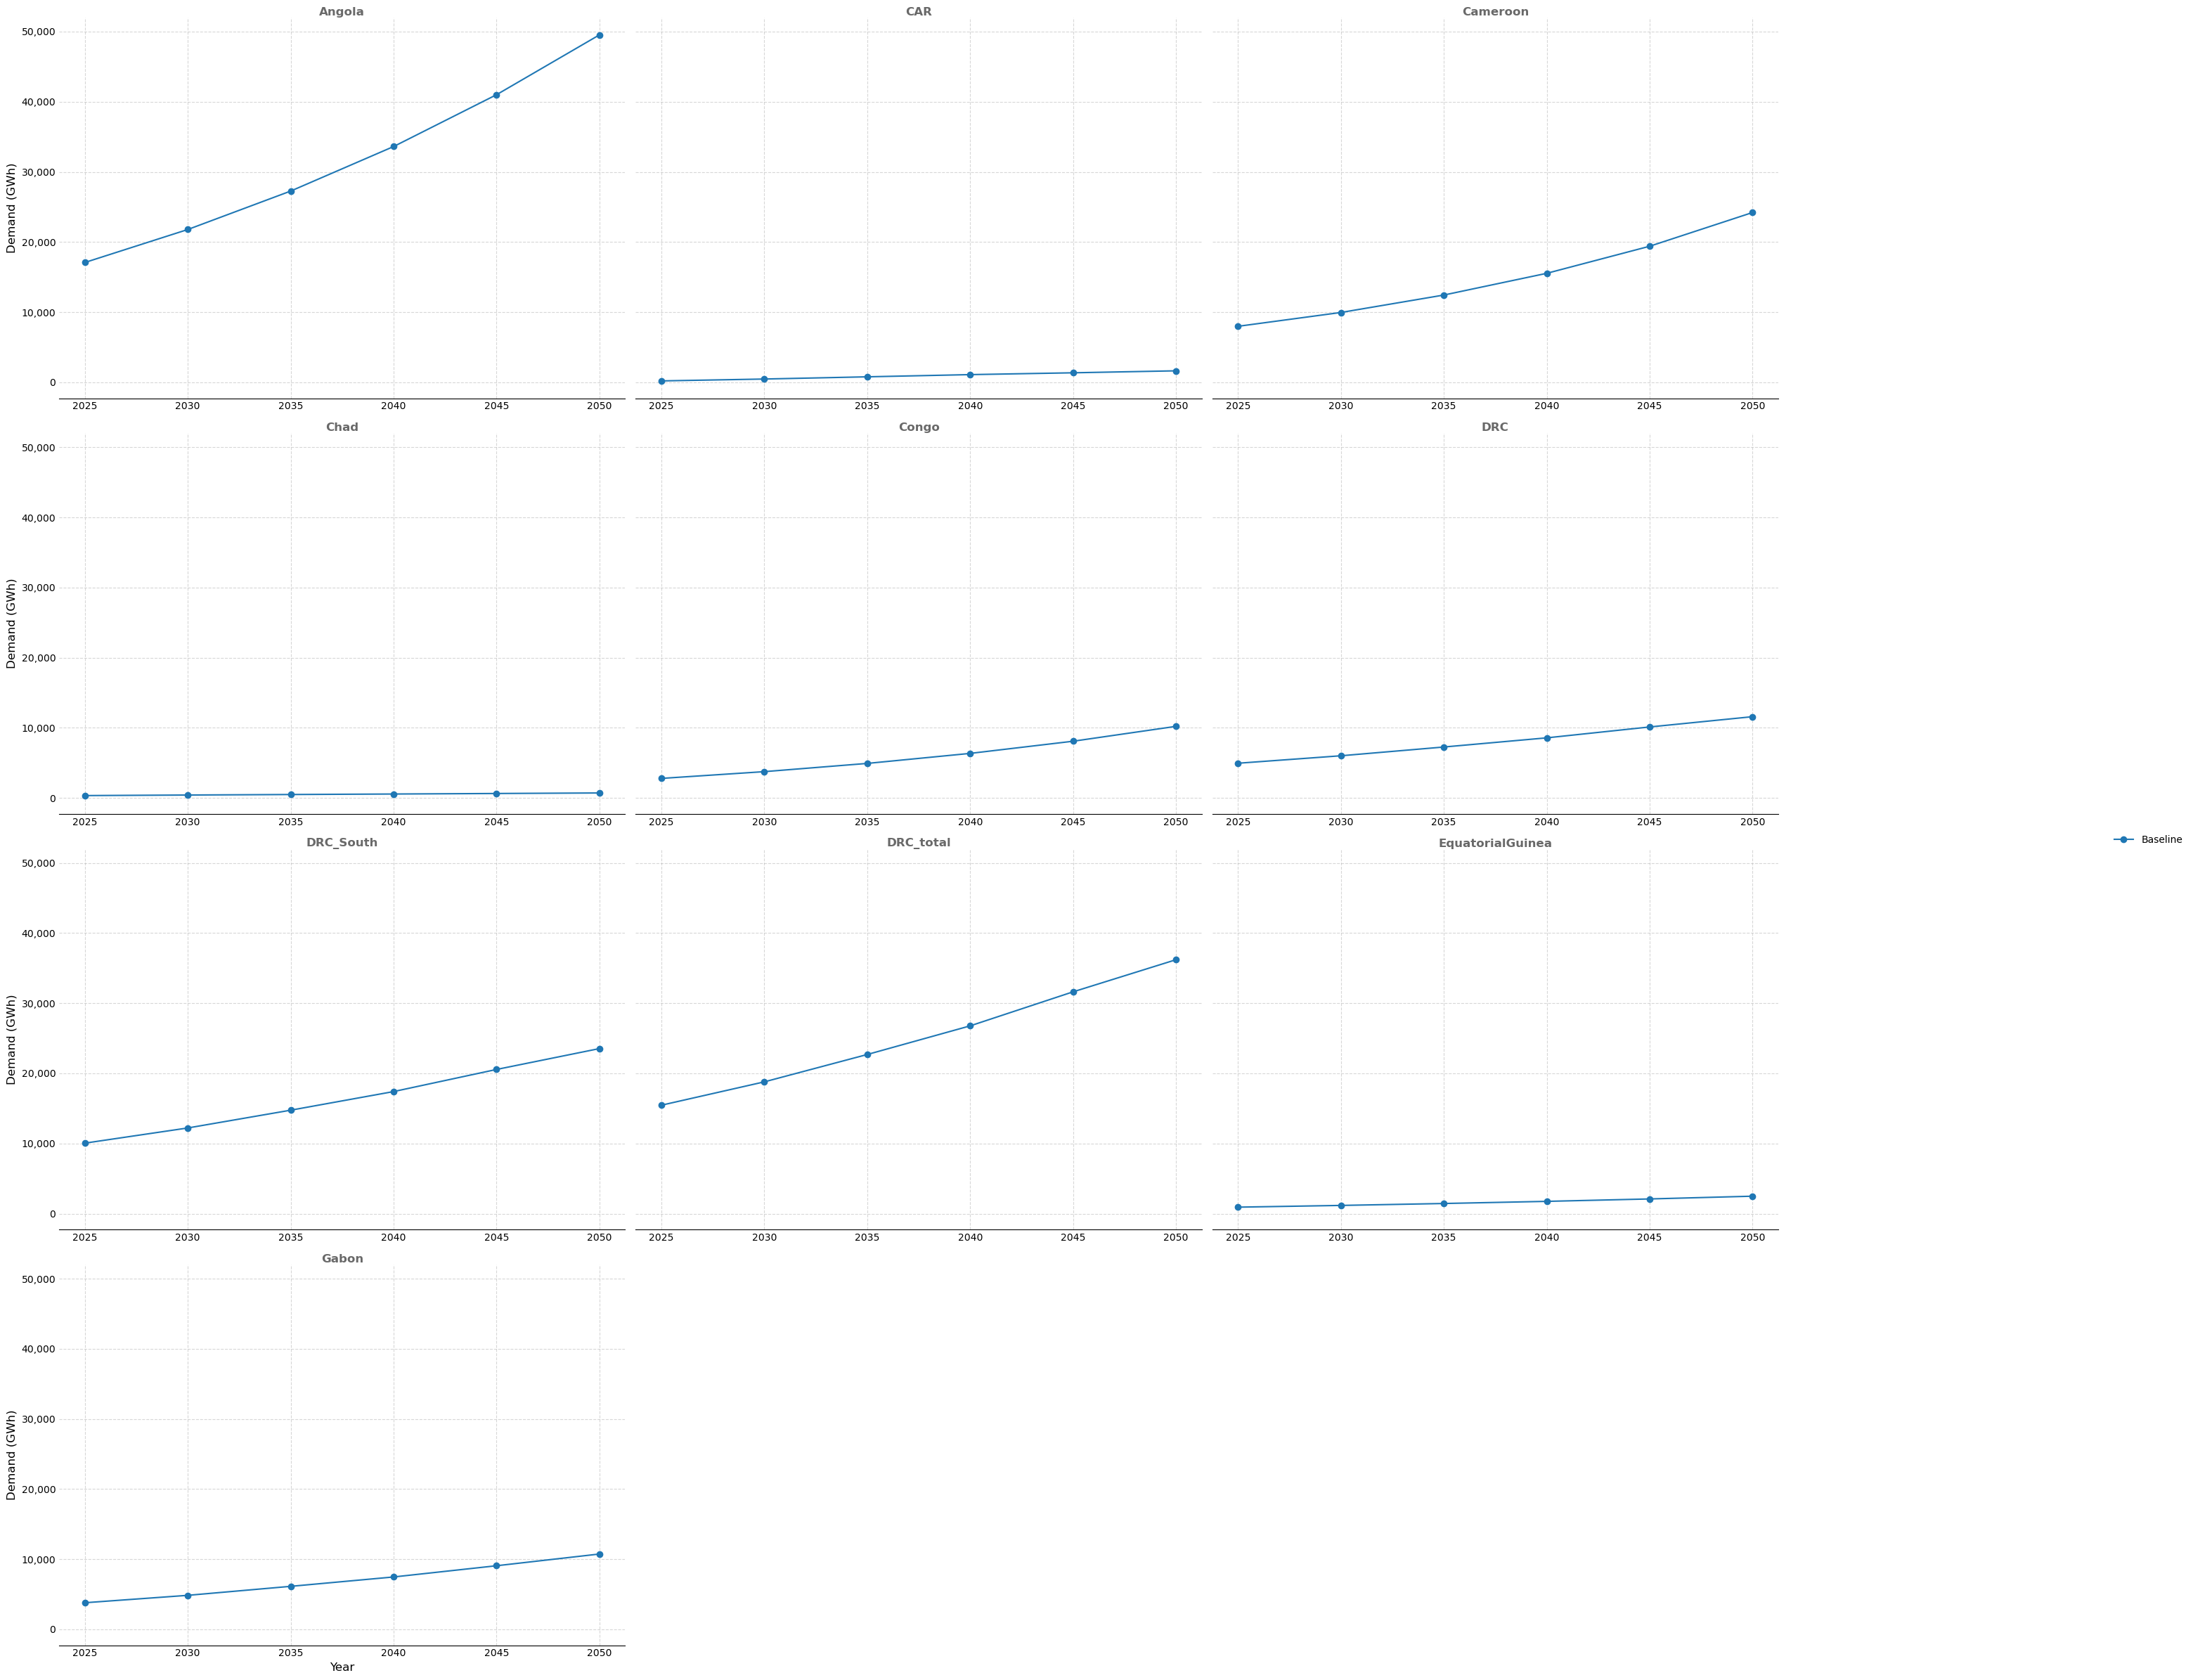

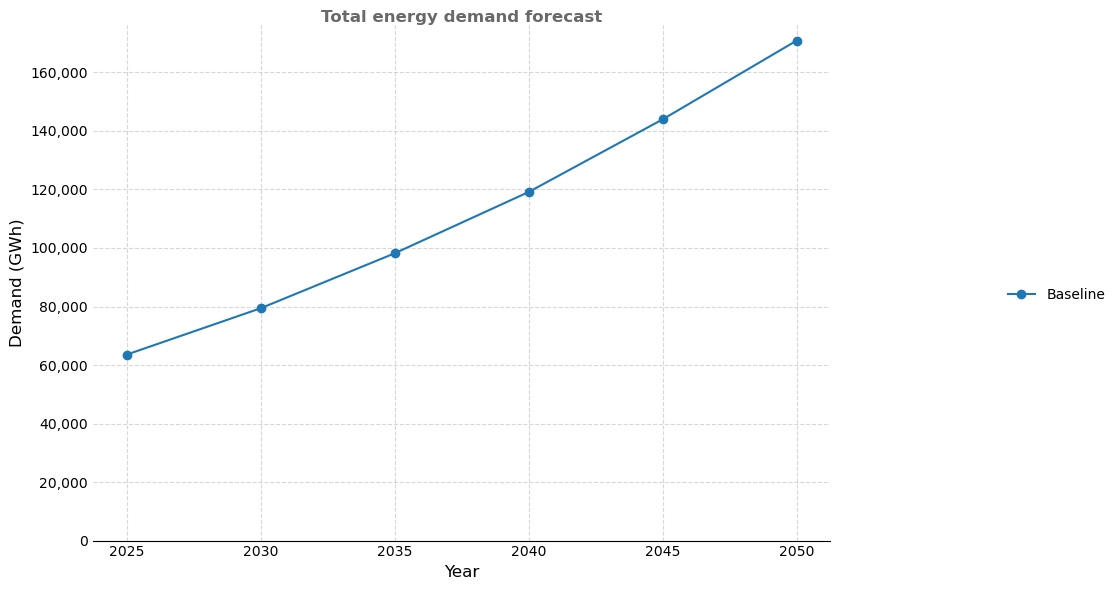

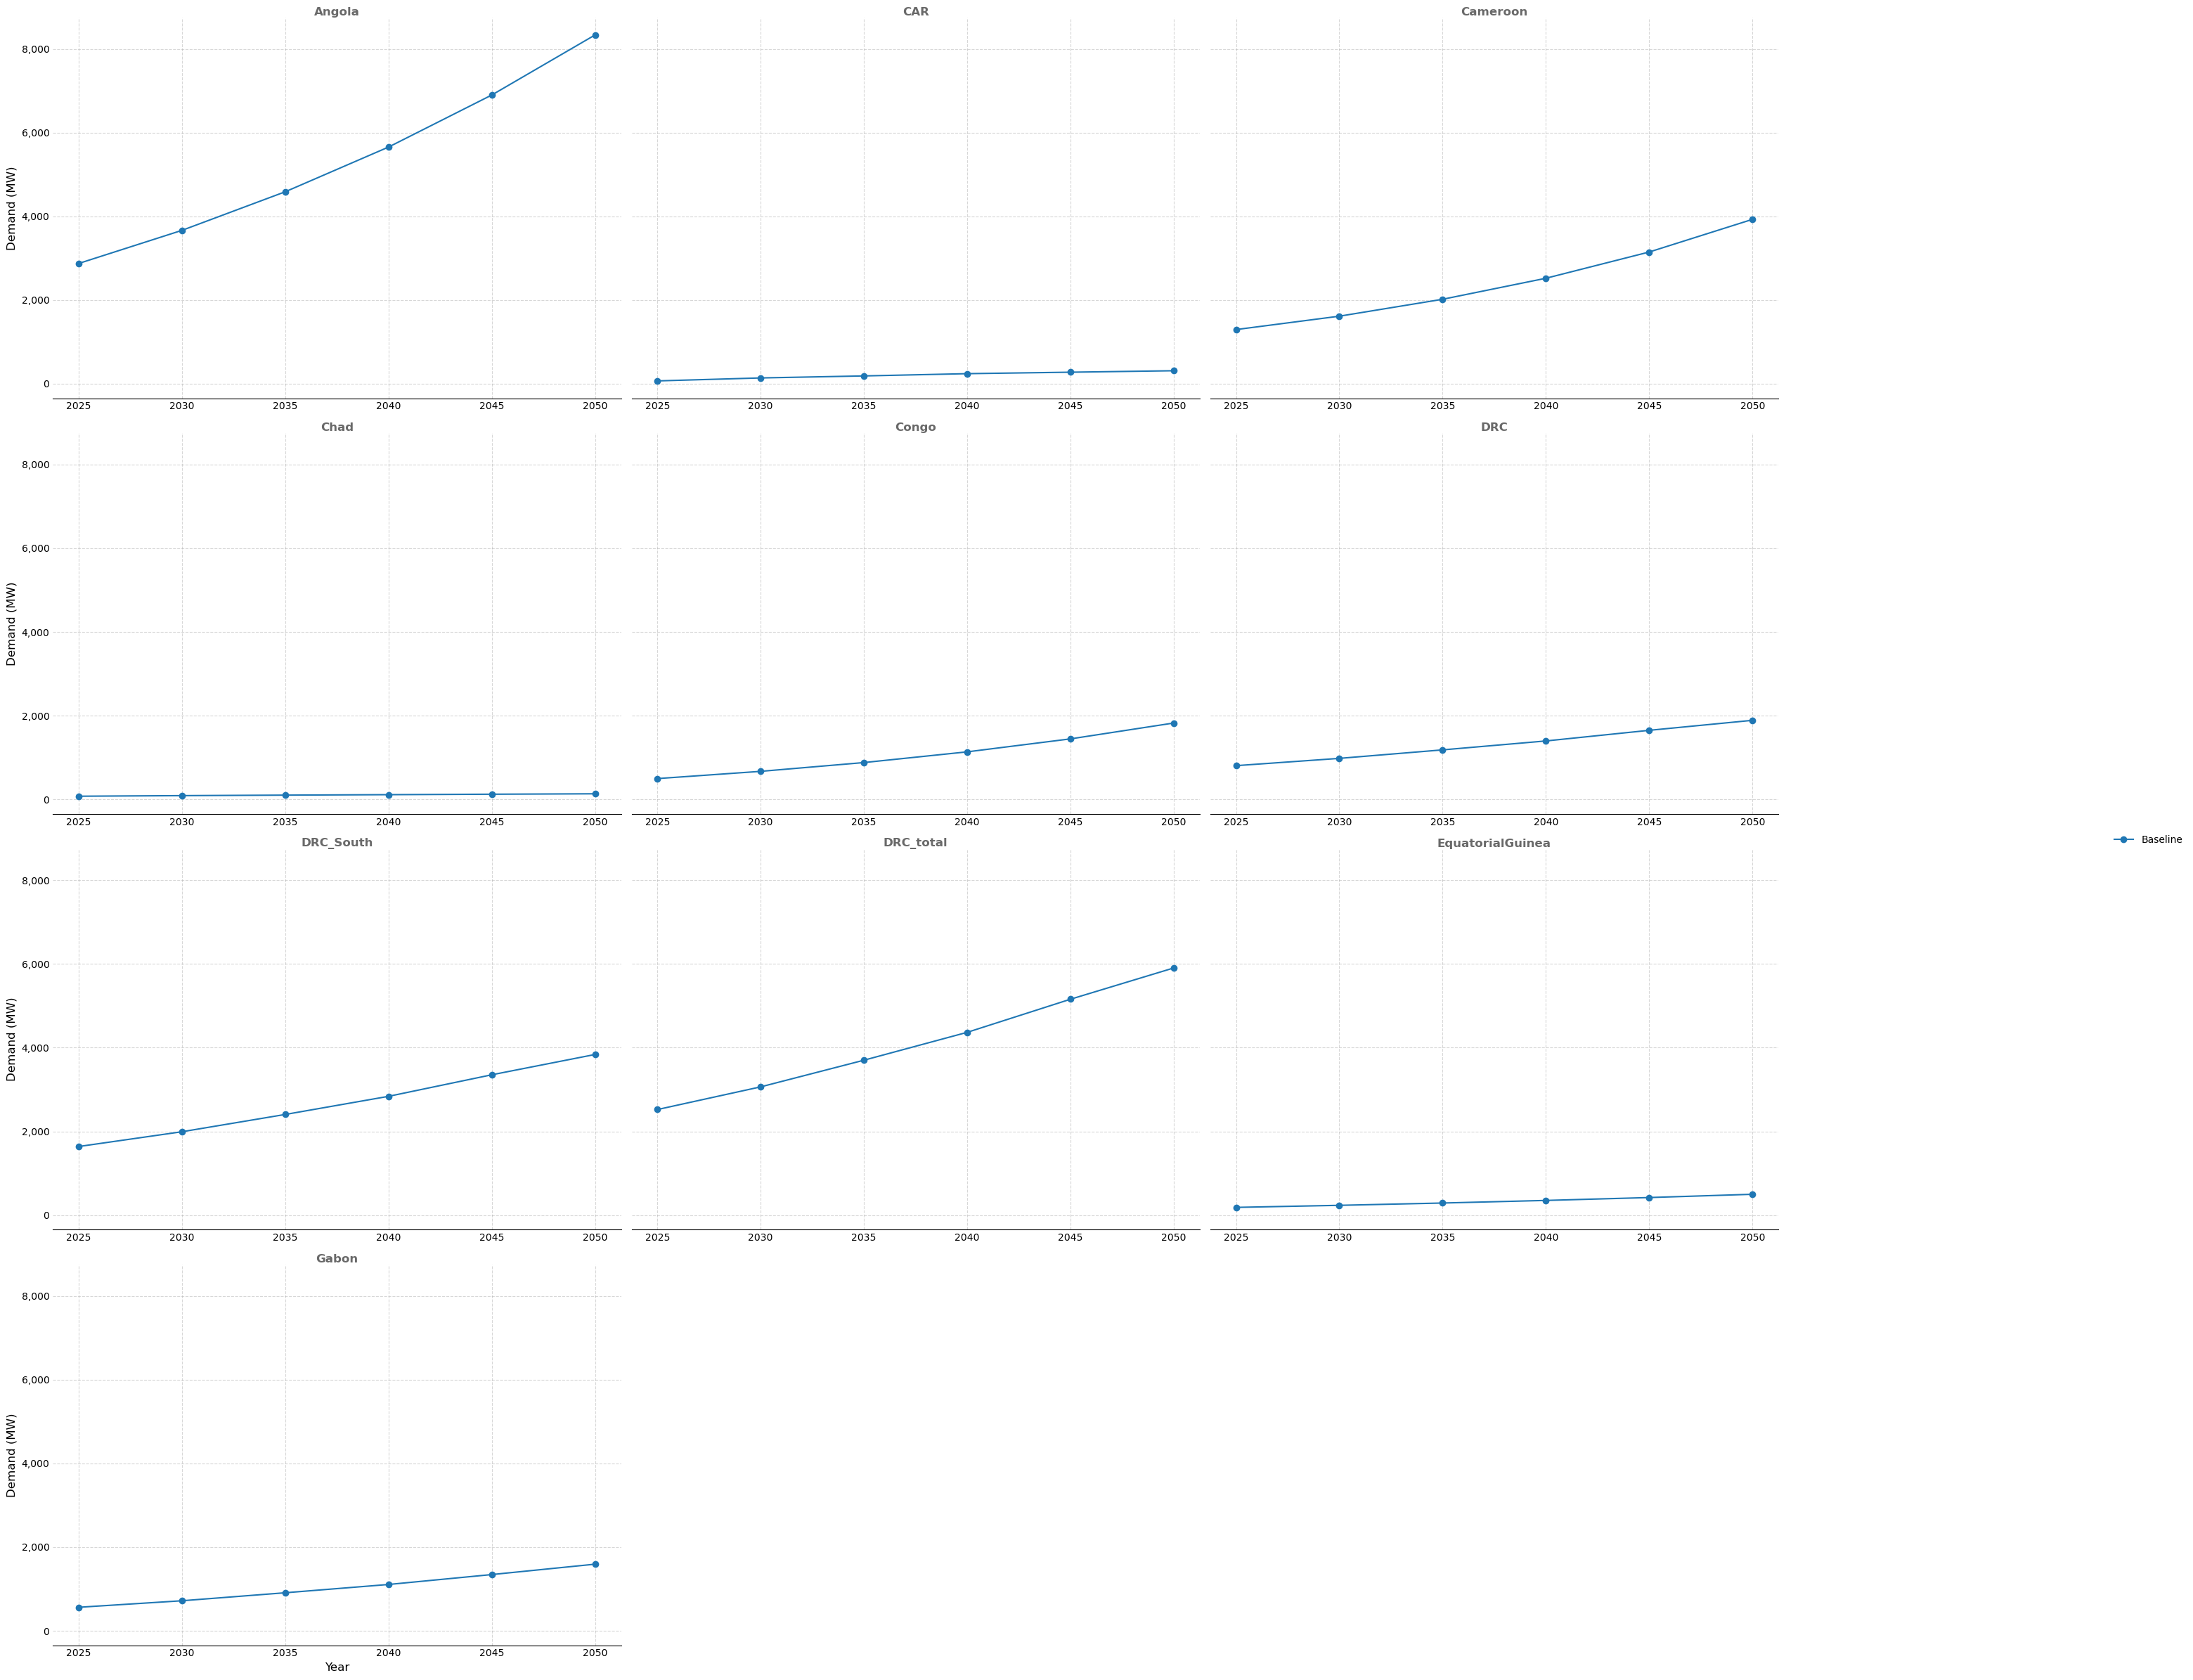

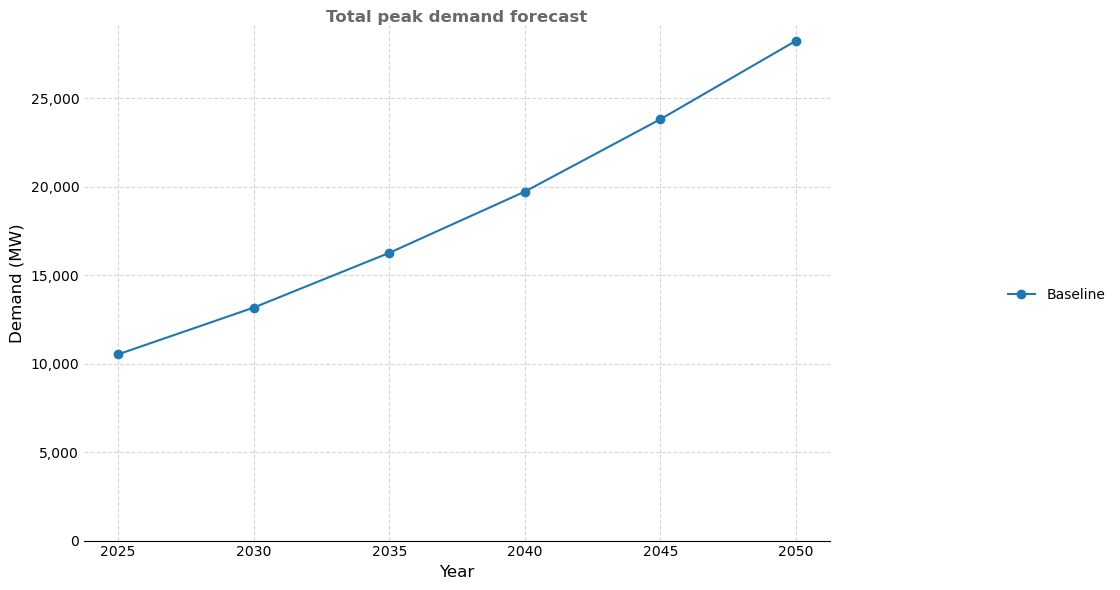

In [4]:
output_dir = Path('output')
output_dir.mkdir(parents=True, exist_ok=True)

year_order = sorted(demand_forecast['year'].unique())
scenario_order = list(dict.fromkeys(demand_forecast['scenario']))

palette = plt.cm.get_cmap('tab20', max(len(scenario_order), 1))
scenario_colors = {scenario: palette(idx) for idx, scenario in enumerate(scenario_order)}

tick_formatter = lambda y, _: f"{y:,.0f}"

type_configs = {
    'Energy': {
        'ylabel': 'Demand (GWh)',
        'zone_title': 'Energy demand forecast by zone',
        'total_title': 'Total energy demand forecast',
        'zone_filename': output_dir / 'energy_demand_by_zone.png',
        'total_filename': output_dir / 'energy_demand_total.png',
    },
    'Peak': {
        'ylabel': 'Demand (MW)',
        'zone_title': 'Peak demand forecast by zone',
        'total_title': 'Total peak demand forecast',
        'zone_filename': output_dir / 'peak_demand_by_zone.png',
        'total_filename': output_dir / 'peak_demand_total.png',
    },
}

for demand_type, cfg in type_configs.items():
    subset = demand_forecast[demand_forecast['type'] == demand_type].copy()
    if subset.empty:
        print(f'No records found for {demand_type} demand.')
        continue

    make_line_plot(
        df=subset,
        # filename=str(cfg['zone_filename']),  # Uncomment to save plot to disk
        filename=None, 
        column_xaxis='year',
        y_column='demand',
        column_subplot='zone',
        series_column='scenario',
        dict_colors=scenario_colors,
        order_index=year_order,
        order_series=scenario_order,
        format_y=tick_formatter,
        xlabel='Year',
        ylabel=cfg['ylabel'],
        title=cfg['zone_title'],
    )
    # print(f"Saved {cfg['zone_filename'].as_posix()}")  # Uncomment if saving to disk

    total = subset.groupby(['scenario', 'year'], as_index=False)['demand'].sum()

    make_line_plot(
        df=total,
        # filename=str(cfg['total_filename']),  # Uncomment to save plot to disk
        filename=None, 
        column_xaxis='year',
        y_column='demand',
        series_column='scenario',
        dict_colors=scenario_colors,
        order_index=year_order,
        order_series=scenario_order,
        format_y=tick_formatter,
        xlabel='Year',
        ylabel=cfg['ylabel'],
        title=cfg['total_title'],
        ymin=0
    )
    # print(f"Saved {cfg['total_filename'].as_posix()}")  # Uncomment if saving to disk
